# Demo 1 - Single forward problem [local]

**Brendan Smithyman** | [bsmithym@uwo.ca](mailto:bsmithym@uwo.ca) | March, 2015

### Import NumPy

In [1]:
import numpy as np

### Import plotting tools from matplotlib and set format defaults

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 150 # Change this to adjust figure size

# Plotting options
font = {
    'family': 'Bitstream Vera Sans',
    'weight': 'normal',
    'size': 8,
}

matplotlib.rc('font', **font)

## Base system configuration

In [3]:
# ------------------------------------------------
# Model geometry

cellSize    = 1             # m
freq        = 2e2           # Hz
nx          = 164           # count
nz          = 264           # count
dims        = (nz, nx)

# ------------------------------------------------
# Model properties


velocity    = 2500          # m/s
vanom       = 500           # m/s
density     = 2700          # units of density
Q           = np.inf        # can be inf

cPert       = np.zeros(dims)
cPert[(nz/2)-20:(nz/2)+20,(nx/2)-20:(nx/2)+20] = vanom
c           = np.fliplr(np.ones(dims) * velocity)
c          += np.fliplr(cPert)
rho         = np.fliplr(np.ones((nz,nx)) * density)

# ------------------------------------------------
# Survey geometry

srcs        = np.array([np.ones(101)*32, np.zeros(101), np.linspace(32, 232, 101)]).T
recs        = np.array([np.ones(101)*132, np.zeros(101), np.linspace(32, 232, 101)]).T
nsrc        = len(srcs)
nrec        = len(recs)
recmode     = 'fixed'

geom        = {
    'src':  srcs,
    'rec':  recs,
    'mode': recmode,
}

# ------------------------------------------------
# Other parameters

ky          = 0
freeSurf    = [False, False, False, False] # t r b l

nPML        = 32

# Base configuration for all subproblems
systemConfig = {
    'dx':       cellSize,   # m
    'dz':       cellSize,   # m
    'c':        c,          # m/s
    'rho':      rho,        # density
    'Q':        Q,          # can be inf
    'nx':       nx,         # count
    'nz':       nz,         # count
    'freeSurf': freeSurf,   # t r b l
    'nPML':     nPML,
    'geom':     geom,
    'freq':     freq,
    'ky':       0,
}

In [4]:
from zephyr.Survey import HelmTx, HelmRx
rxs = [HelmRx(loc, 1.) for loc in recs]
txs = [HelmTx(loc, 1., rxs) for loc in srcs]

### Plotting functions

These are convenience functions to allow us to set plotting limits in one place. Since we're defining these with closures to save effort, they need to go after the system configuration to grab things like the geometry after it's defined.

In [5]:
sms = 4
rms = 0.5

def plotField(u):
    clip = 0.1*abs(u).max()
    plt.imshow(u.real, cmap=cm.bwr, vmin=-clip, vmax=clip)

def plotModel(v):
    lclip = 2000
    hclip = 3000
    plt.imshow(v.real, cmap=cm.jet, vmin=lclip, vmax=hclip)

def plotGeometry():
    
    srcpos = srcs[activeSource][::2]
    recpos = recs[:,::2]
    
    axistemp = plt.axis()
    plt.plot(srcpos[0], srcpos[1], 'kx', markersize=sms)
    plt.plot(recpos[:,0], recpos[:,1], 'kv', markersize=rms)
    plt.axis(axistemp)

## Numerical Examples

### Base configuration

In this configuration, the PML is set to a reasonable default and no free-surface conditions are imposed.

In [6]:
from zephyr.Kernel import SeisFDFDKernel
sp = SeisFDFDKernel(systemConfig)

In [7]:
activeSource = 50
u, d = sp.forward(txs[activeSource], False)
b = sp.backprop(txs[activeSource], np.ones((len(txs[activeSource].rxList),)))
u.shape = (nz, nx)
b.shape = (nz, nx)

## Results

### Wavefield results

The velocity model is shown along with wavefields for three different cases, computed above.

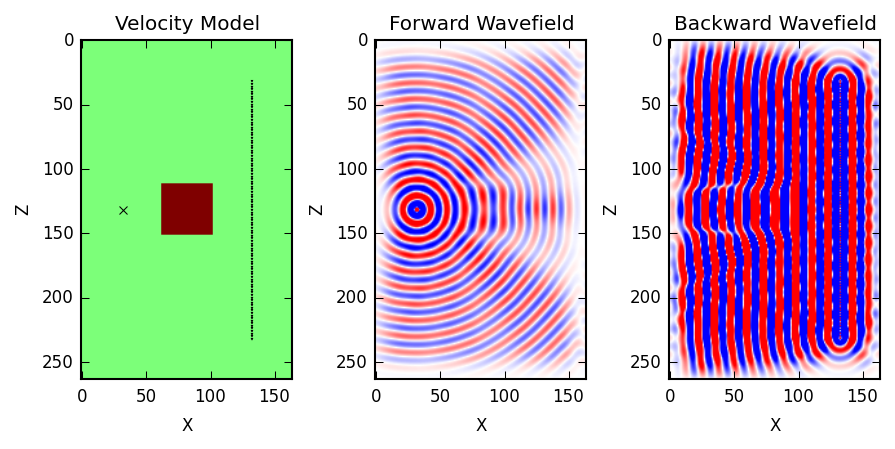

In [8]:
fig = plt.figure()

ax1 = fig.add_subplot(1,3,1)
plotModel(c)
plotGeometry()
ax1.set_title('Velocity Model')
ax1.set_xlabel('X')
ax1.set_ylabel('Z')

ax2 = fig.add_subplot(1,3,2)
plotField(u)
ax2.set_title('Forward Wavefield')
ax2.set_xlabel('X')
ax2.set_ylabel('Z')

ax3 = fig.add_subplot(1,3,3)
plotField(b)
ax3.set_title('Backward Wavefield')
ax3.set_xlabel('X')
ax3.set_ylabel('Z')

fig.tight_layout()

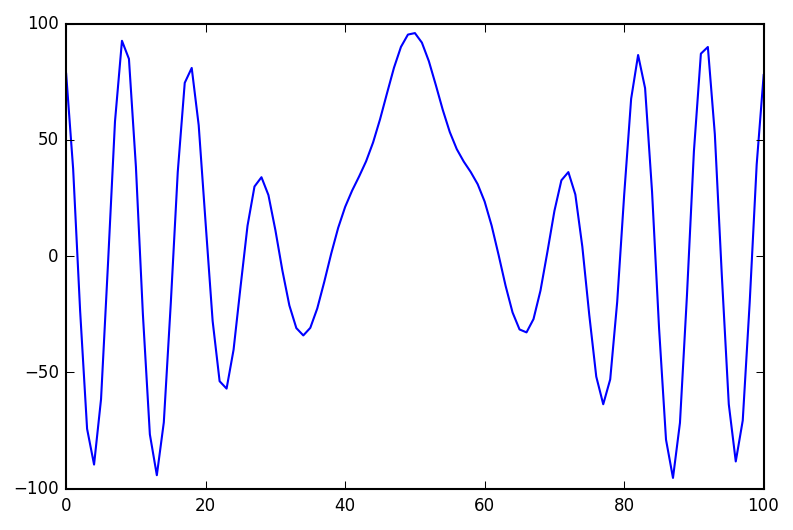

In [9]:
# norm = abs(d).max()

fig = plt.figure()

plt.plot(d.real)